In [144]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import paper_tools
import census
import numpy as np
#load the census data
#sheffield
#bbox = np.array([430,440,381,391])
bbox = np.array([433,437,382,386])
pathtodata = '/home/ubuntu/hetMOGPintegral/hetGPIntegralexperiments/'
shapefilename=pathtodata+'oaboundaries/Output_Area_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp'
oafilename=pathtodata+'oa_to_lsoa/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv'
randomoafilename = pathtodata+'oa_to_lsoa/RANDOM_SOAS_2.csv' #this file contains MSOA that have been randomly assigned
oadescfilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EW_2011STATH_NAT_OA_REL_1.4.4/KS102EWDESC0.CSV'
oadatafilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EWDATA.CSV'

#X,Y,testX,testY = census.get_census_data(box=bbox*1000,verbose=True)
X1,Y1,oaX1,oaY1 = census.get_census_data(shapefilename=shapefilename,
                                         oafilename=oafilename,
                                         oadescfilename=oadescfilename,
                                         oadatafilename=oadatafilename,
                                         box=bbox*1000,verbose=True,refresh=False)
X1 = np.c_[X1,np.zeros([len(X1),1])]
oaX1 = np.c_[oaX1,np.zeros([len(oaX1),1])]

Trying cache...
Cache loaded.
Loaded from cache, 18 training polygons and 280 testing polygons


In [145]:
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
import GPy
kern = GPy.kern.RBF(2, lengthscale=10.0, variance = 1.0, ARD=False)
oldshapek = ShapeIntegral(X1.shape[1],input_space_dim=2,Nperunit=5,kernel=kern)
m = GPy.models.GPRegression(X1,Y1,oldshapek)
m.Gaussian_noise=10.0
#predY,_=m.predict(testX)#[0:3,:]

In [146]:
def oldplotsimplexes(X,c='k',lw=1):
    for x in X:
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
        else:
            print("PLOTTING A POINT! AHH")
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            
def plotsimplexes(X,c='k',lw=1):
    for x in X:
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                edges.append(tri[[0,1,2,3]])
                edges.append(tri[[2,3,4,5]])
                edges.append(tri[[4,5,0,1]])
                
                
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
        else:
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            

            
#def plotsimplexes(X,c='k',lw=1):
#    for x in X:
#        if x[-1]==0:
#            for tri in x[0:-1].reshape(int(len(x)/6),6):
#                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c,lw=lw)
#        else:
#            print("PLOTTING A POINT! AHH")
#            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
            


In [147]:
Xa,Xb = np.meshgrid(np.linspace(432,438,25),np.linspace(381,387,25))
testX = np.c_[Xa.flatten(),Xb.flatten()]
testX = np.c_[testX,np.ones([testX.shape[0],X1.shape[1]-2])]
#m.optimize()
#preds,_ = m.predict_noiseless(testX)

In [148]:
bbox

array([433, 437, 382, 386])

In [149]:
from dp4gp import datasets
from dp4gp import dp4gp
from dp4gp import histogram
from dp4gp.utils import dp_normalise, dp_unnormalise
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

#datasets.prepare_preloaded_prices('sheffield_houseprices.csv', col_list=[], since=2000, boundingbox=bbox[[0,2,1,3]]*1000, N=5000)
dataset = pd.read_csv('sheffield_houseprices.csv') #sheffield
#inputs = np.vstack([dataset['easting'].values,dataset['northing'].values]).T
#ys = dataset['price'].values

In [150]:
X2 = np.c_[dataset['easting'].values/1000,dataset['northing'].values/1000,np.full([len(dataset),X1.shape[1]-3],np.NaN),np.ones(len(dataset))]
tempY2 = dataset['type'].values
#plt.plot(east[dataset['type']==housetype].values/1000,north[dataset['type']==housetype].values/1000,pattern,markersize=2)

In [151]:
Y2 = np.zeros(len(tempY2))[:,None]
for i,t in enumerate(list(set(tempY2))):
    Y2[tempY2==t,0]=1.0*i

In [152]:
X = [X1,X2]
Y = [Y1,Y2]

# Analysis

In [153]:
import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.model import HetMOGP
from hetmogp import multi_output
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import GPy
import matplotlib.pyplot as plt
from GPy.kern import Kern
from GPy.core.parameterization import Param
from paramz.transformations import Logexp
import math
from scipy.misc import factorial
import numpy as np
import math
import random
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral

In [154]:
latentkern = GPy.kern.RBF(2,lengthscale=10.0,variance=1.0)
k = ShapeIntegral(X1.shape[1],2,kernel=latentkern,Nperunit=3)
m = GPy.models.GPRegression(X1,Y1,k)
m.Gaussian_noise.fix(0.001)

array([0])

In [155]:
m

GP_regression.,value,constraints,priors
shapeintegral.variance,1.0,+ve,
shapeintegral.lengthscale,1.0,+ve,
Gaussian_noise.variance,0.001,+ve fixed,


In [156]:
Xa,Xb = np.meshgrid(np.linspace(bbox[0],bbox[1],35),np.linspace(bbox[2],bbox[3],35))
testX = np.c_[Xa.flatten(),Xb.flatten()]
testX = np.c_[testX,np.ones([len(testX),X1.shape[1]-2])]
#preds,_ = m.predict_noiseless(testX)

In [157]:
set(dataset['type'])

{'D', 'F', 'O', 'S', 'T'}

In [158]:
plt.figure(figsize=[20,20])
plt.contourf(Xa, Xb, preds.reshape(Xa.shape[0],Xa.shape[1]))
plt.colorbar()
for i in range(len(X1)):
    v = m.kern.placepoints(X1[i:(i+1),:-1])[1]
    popden = (Y1[i,0]/v)/10000
    if popden>1:
        popden=1
    c = np.array([popden,popden,popden,1])
    plt.scatter(X1[i,0:-1:2],X1[i,1::2],100,c=c[None,:])
    #plotsimplexes(X[i:(i+1),:],c=c)
#plotsimplexes(X[0:5,:])
#c = dataset['price'].values/(np.mean(dataset['price'].values*2))
#c[c>1]=1
#c = np.c_[c*0,c*0,c]
#plt.scatter(dataset['easting'].values/1000,dataset['northing'].values/1000,3,c)
east=dataset['easting']
north=dataset['northing']
for housetype, pattern in enumerate(['b.','rx','g+','yo']):
    plt.plot(east[dataset['type']==housetype].values/1000,north[dataset['type']==housetype].values/1000,pattern,markersize=2)
plt.axis('equal');
plt.xlim(bbox[[0,1]])
plt.ylim(bbox[[2,3]])
#plt.savefig('demo.png')

NameError: name 'preds' is not defined

<Figure size 1440x1440 with 0 Axes>

# SVI etc

### Temporary simplified data

In [159]:
#X[0] = 1.0*np.array([[435,383,436,383,435,384,436,384,436,383,435,384,436,383,437,383,436,384,437,384,437,383,436,384,0]
#                     ,[435,384,436,384,435,385,436,385,436,384,435,385,436,384,437,384,436,385,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,0]
#                     ,[437,384,438,384,437,385,438,385,437,384,438,385,437,384,438,384,438,385,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,0]
#                     ,[440,384,441,384,440,385,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,0]
#                     ,[438,386,439,386,439,387,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,0]])
#Y[0] = 1.0*np.array([[1135],[7229],[8525],[6000],[4000]])
##X[1] = 1.0*np.array([[435,383],[437,386],[438,386],[437,388],[435,385]])
#X[1] = np.random.rand(20,2)
#X[1][:,0] = X[1][:,0]+435
#X[1][:,1] = X[1][:,1]+383
#X[1] = np.c_[X[1],np.full([len(X[1]),X[0].shape[1]-3],np.NaN),np.ones(len(X[1]))]
##Y[1] = np.array([[3,4,4,4,3]]).T
#Y[1] = (3+np.floor(((X[1][:,0]*3) % 1)*2))[:,None]

#Xa,Xb = np.meshgrid(np.linspace(bbox[0],bbox[1],15),np.linspace(bbox[2],bbox[3],15))
#testX = np.c_[Xa.flatten(),Xb.flatten()]
#testX = np.c_[testX,np.ones([len(testX),X[0].shape[1]-2])]


In [160]:
Z = np.random.rand(40,X[0].shape[1])*4
Z[:,0]+=433 #[433,437,382,386])
Z[:,1]+=382
Z[:,2:-1]=np.NaN
Z[:,-1]=1
kern_list=[ShapeIntegral(X[0].shape[1],2,kernel=GPy.kern.RBF(2,lengthscale=1.0),Nperunit=2)]

In [161]:
X[0].shape

(18, 2929)

In [162]:
X[1].shape

(5000, 2929)

In [163]:
#X[1] = X[1][::5,:]

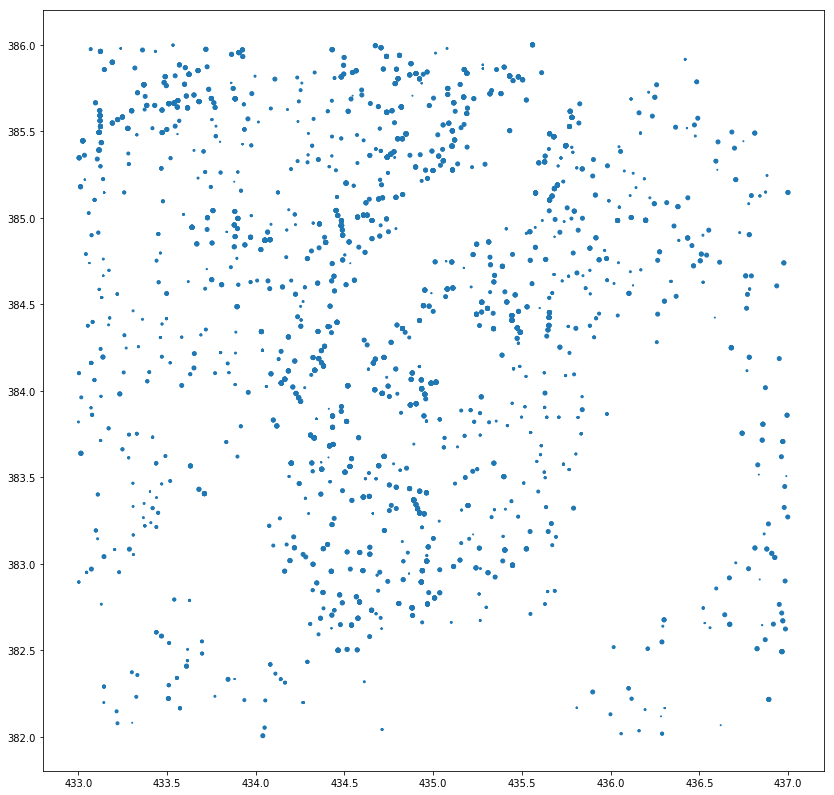

In [164]:
plt.figure(figsize=[14,14])
plt.scatter(X[1][:,0],X[1][:,1],Y[1][:,0]**2)

In [165]:
#X[0]=X[0][::1,:]
#Y[0]=Y[0][::1,:]
X[1]=X[1][::20,:]
Y[1]=Y[1][::20,:]

In [166]:
X[0].shape

(18, 2929)

In [167]:
X[1].shape

(250, 2929)

In [168]:
Y[1].shape

(250, 1)

In [169]:
Z.shape

(40, 2929)

In [170]:
# MODEL and INFERENCE
Q=1
#likelihoods_list = [Gaussian(sigma=0.001),Bernoulli(gp_link=GPy.likelihoods.link_functions.Probit())]#,Gaussian(sigma=1.0)]
likelihoods_list = [Gaussian(sigma=10), Categorical(5)]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)

model = HetMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=10)

In [171]:
model.kern_list[0].variance = 100.0

In [172]:
X[1].shape

(250, 2929)

In [173]:
model=VEM(model,vem_iters=3,maxIter_perVEM=4,optZ=False,verbose=True,verbose_plot=False,non_chained=True)

iteration (1) VE step, mini-batch log_likelihood=[-inf]
iteration (1) VM step, mini-batch log_likelihood=[-1326381.3891181]
iteration (2) VE step, mini-batch log_likelihood=[-1565725.1513367]
iteration (2) VM step, mini-batch log_likelihood=[-1325250.2203373]
iteration (3) VE step, mini-batch log_likelihood=[-1564902.33531612]
iteration (3) VM step, mini-batch log_likelihood=[-inf]


In [174]:
testX

array([[433.        , 382.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [433.11764706, 382.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [433.23529412, 382.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       ...,
       [436.76470588, 386.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [436.88235294, 386.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [437.        , 386.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ]])

In [175]:
model

HetMOGP.,value,constraints,priors
inducing inputs,"(40, 2929)",fixed,
m_u,"(40, 1)",fixed,
L_u,"(820, 1)",fixed,
shapeintegral.variance,100.11955104634096,+ve,
shapeintegral.lengthscale,0.9576191540675882,+ve,
B_q0.W,"(5, 1)",,
B_q0.kappa,"(5,)",+ve fixed,


In [176]:
preds,_ = model.predictive(testX,output_function_ind=0)

(382, 386)

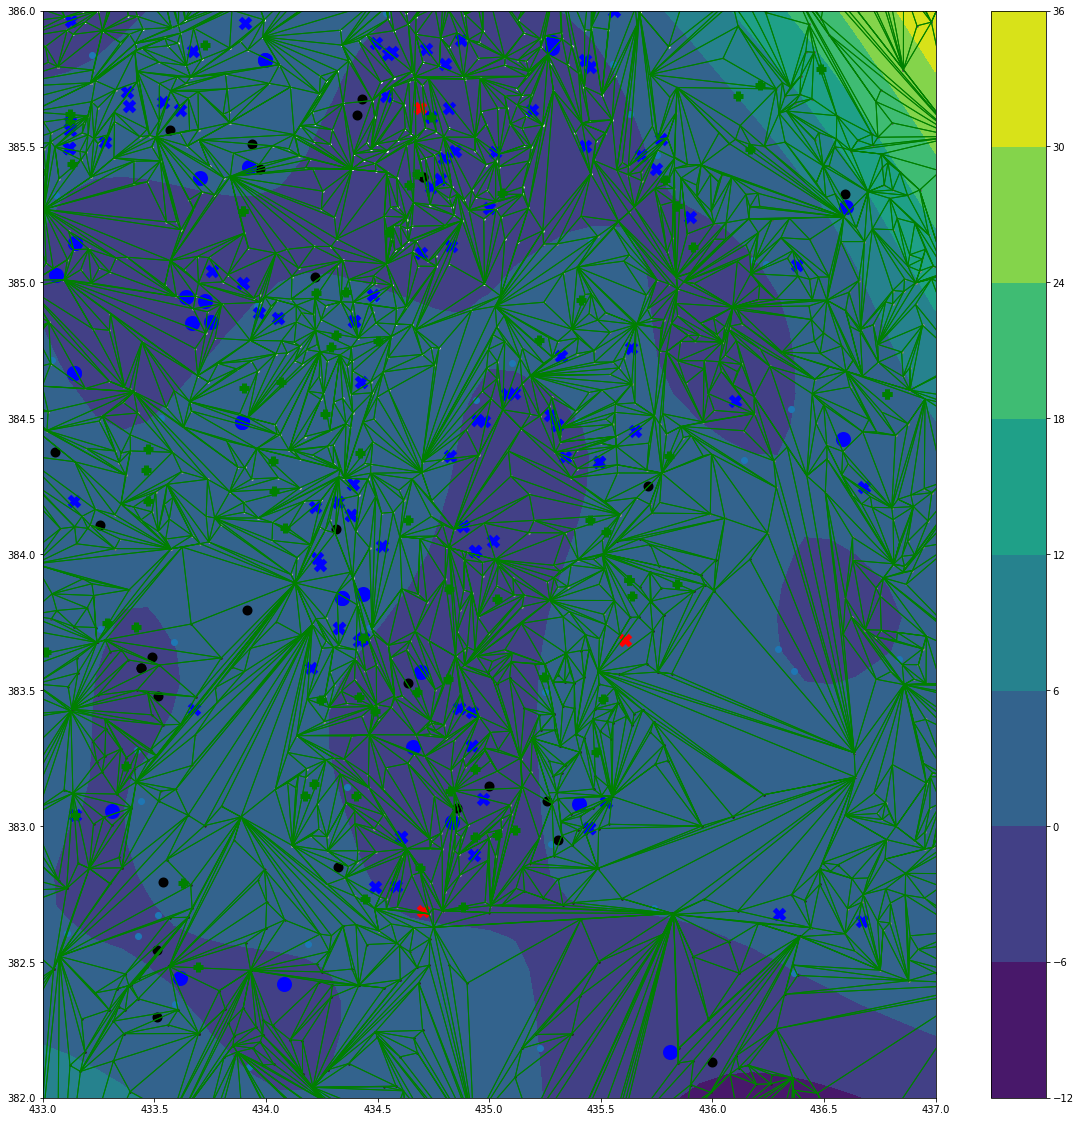

In [178]:
plt.figure(figsize=[20,20])
ax=plt.gca()
plt.contourf(Xa, Xb, preds.reshape(Xa.shape[0],Xa.shape[1]))
plt.colorbar()
def plotsimplexes(X,Y,c,lw=1):
    for i,(x,y) in enumerate(zip(X,Y)):
        #plt.text(x[0],x[1],"%0.1f"%y)
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c,lw=lw)
        else:
            plt.plot(x[0],x[1],['xr','ob','+g','.k','bx'][int(y[0])],mew=5,markersize=10)
plotsimplexes(X[1],Y[1],'g-')
plotsimplexes(X[0],Y[0],'g-')
plt.scatter(Z[:,0],Z[:,1])

for i in range(len(X[0])):
    v = m.kern.placepoints(X[0][i,:-1])[1]
    popden = (Y[0][i,0]/v)/10000
    if popden>1:
        popden=1
    c = np.array([popden,popden,popden,1])
    plt.scatter(X[0][i,0:-1:2],X[0][i,1::2],1,c=c[None,:])
plt.xlim([bbox[0],bbox[1]])
plt.ylim([bbox[2],bbox[3]])

In [ ]:
model.predictive(testX[0:1,:],output_function_ind=0)

In [ ]:
model.predictive(oaX1[0:1,:],output_function_ind=0)

In [ ]:
preds,_ = model.predictive(X1[0:1,:],output_function_ind=0)

In [ ]:
preds,_ = model.predictive(oaX1[0:4,:],output_function_ind=0)